<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/26.%20PI_P%3D30_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
P_max = 30 #in dBm

In [4]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-11-01 03:53:02--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-11-01 03:53:02--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5921809b3e80ec5db2cbf826df.dl.dropboxusercontent.com/cd/0/inline/BZE9sWTn6h-1_aj-xtas5dKGYJmCg7aOdJKIWITIWRPqu42lc_aQa8s_zuEc0m73qJVqvcCS8N_AeOEplqzvUVzNXonMfqMZOh-joPRdaPNsIM5ivtU0DYw8_hM28gYNzgOZXQqSeIALfyG32edct0Q1/file# [following]
--2021-11-01 03:53:03--  https://uc5921809b3e80ec5db2cbf826df.dl.dr

In [5]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-11-01 03:53:05--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-11-01 03:53:06--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95b1a3136c683e3c056377ec07.dl.dropboxusercontent.com/cd/0/inline/BZG04kZy5RdPWBgdcFlyUJicV2BBcoVbptewtYoPAz3CD8CO2XllhJlaEm-sOu8fEAAs10BJwIuOHG1j8poSSp95vgwITH5_3kl3emrAJ4XvPzdSch013SwK_cEeBCyn0pHaECBLN23mQV8NKtUmSgZV/file# [following]
--2021-11-01 03:53:06--  https://uc95b1a3136c683e3c056377ec07.dl.dropboxusercontent.com/cd/0/inline/BZG04kZy5RdPWBgdcFlyUJicV2BBcoVbptewtYoPAz3CD8CO2XllhJlaEm-sOu8fEAAs10BJwIuOHG1j8poSSp95vgwITH5_3kl3emrAJ4Xv

In [5]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [9]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [10]:
def PIacquisition(Xsamples, X, model):
  Xsamples = Xsamples[np.newaxis,:]
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  probs = norm.cdf((mu - best) / (std+1E-30))
  return -probs[0]

In [11]:
#optimize the acquisition function
def opt_acquisition(X, y, model):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  
  for i in range(1):
    result = dual_annealing(PIacquisition, bounds, args=(X,model))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [12]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_PI_P=30.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_PI_P=30.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_PI_P=30.npy")

x_next is [ 24.45633064  11.66198441 -29.48333857 -14.51134638  26.3018408
  27.44623802 -11.31032201  28.43836005 -13.15199058  17.92718267
 -22.78509618  14.22705011  21.77614406  22.5776977   25.07138388
   3.47573239 -17.45452859  22.31565649 -18.65273645  27.3685168 ]
f()=47.224247, actual=42.887
0


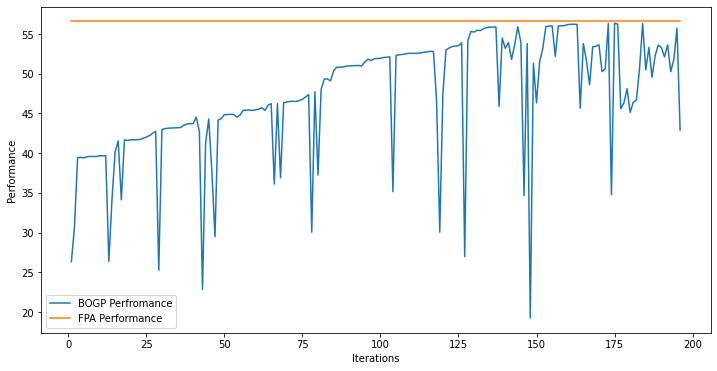

x_next is [ 29.9999313   29.99915568  23.1965013   16.50148081  29.99750105
  29.99750667   8.68128294  29.99982601 -30.99413583  29.99563831
  29.99609665   5.41983579  29.99814569  23.77923073   2.59090513
  29.99513988  29.99802053  29.99873153  29.99959425  29.99813215]
f()=52.173244, actual=53.304
1


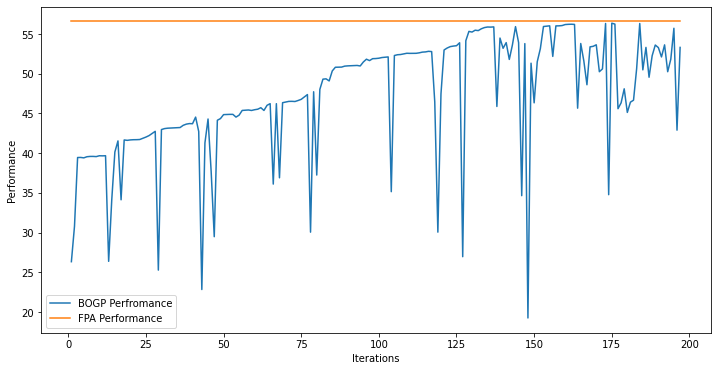

x_next is [ 29.99979522  29.9993565   17.23177159  24.15354801  29.99915253
  29.99999597  15.67329449  29.99952892 -30.99728377   6.09092189
  22.24501194 -12.90176291  29.99949941  29.9960253  -12.46213613
  29.99951614  16.54160203  29.99983419  29.99964141  29.99994301]
f()=52.953710, actual=54.386
2


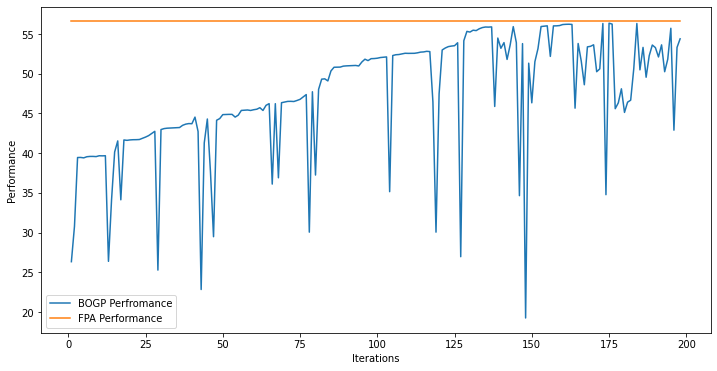

x_next is [ 29.99980811  29.99950446  -6.87699551  29.9999276   29.99951812
  29.99994259  14.81610232  29.999718   -30.99899663   8.63739223
  29.9970276    4.86118942  29.99974579  29.99958202   2.50348746
  29.99990142  29.99939278  29.9992208   29.99961418  29.999924  ]
f()=52.852356, actual=55.441
3


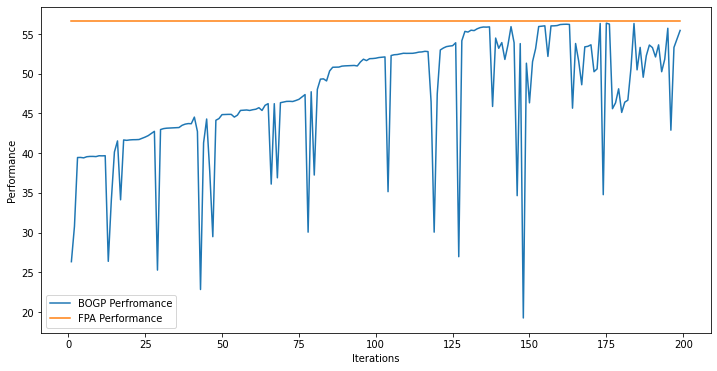

x_next is [ 29.99979147  29.99678158  -6.10148665  15.01926178  29.99752149
  29.99831484   4.29906242  29.99686418 -30.99818872   6.27797513
  29.99992187   0.19950135  29.99878823  29.99451592   8.78077149
  29.99958245  29.9929157   29.99890199  29.99694381  29.99900813]
f()=54.825115, actual=55.334
4


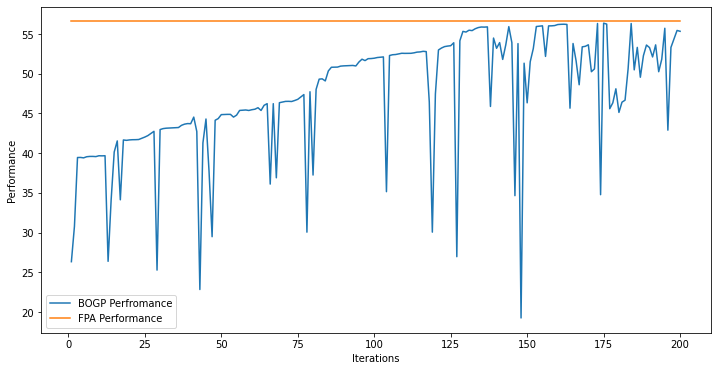

x_next is [ 29.99946139  29.99941992  -3.92472697  24.25129346  29.99924834
  29.99964269   9.28343761  29.99992415 -30.99831937   7.47616964
  29.99795371   1.65744374  29.99955982  29.99800125   4.70391553
  29.99947427  29.99902374  29.99923541  13.34030528  29.99929296]
f()=54.806827, actual=57.177
5


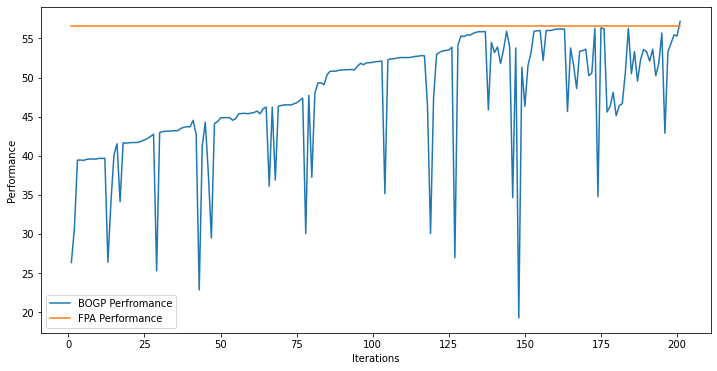

x_next is [ 29.99788006  29.97510828  -3.65764884  24.30814145  29.99170048
  29.99342564   9.17679405  29.9989432  -30.97515681   7.75347338
  29.99421612   1.49236674  29.98756699  29.98282197   4.56089771
  29.97728155  29.99503914  29.97982888  11.83461498  29.99500216]
f()=57.229317, actual=56.928
6


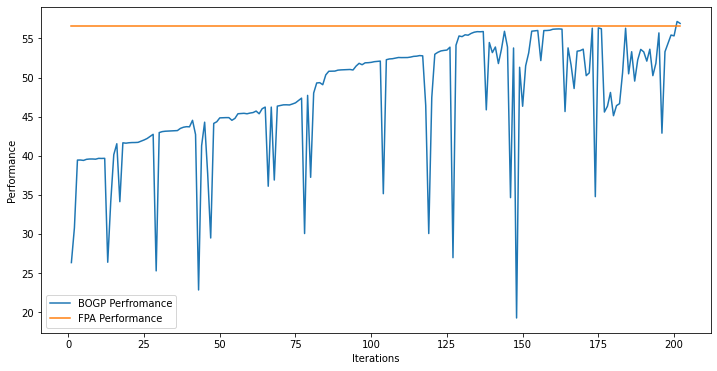

x_next is [ 29.99141396  29.98366853  -4.22345621  24.21059178  29.95390875
  29.97936252   9.36504133  29.99409665 -30.99522367   7.12660717
  29.99301645   1.80800654  29.99387401  29.97959892   4.8793099
  29.99195873  29.97926617  29.99164992  14.80617647  29.97193267]
f()=57.343886, actual=57.364
7


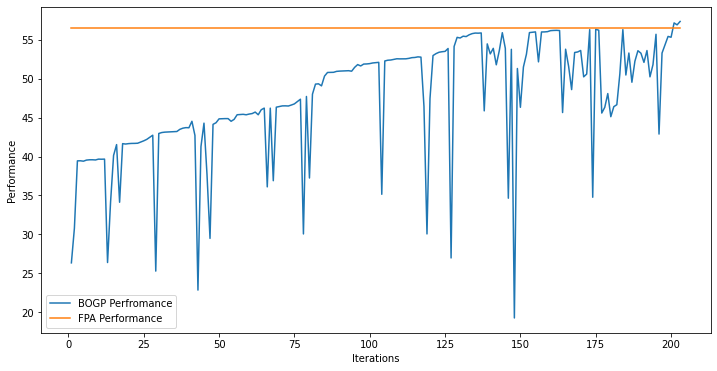

x_next is [ 29.9137736   29.77545179  -5.5682052   29.87647412  29.57258814
  29.17324698   5.97803841  29.69177467 -30.91979939  -9.56237181
  29.80696327   7.89310566  29.83799515  29.72704684  20.08498499
  29.90008703  29.9426735   29.86086617   3.85382091  29.59956158]
f()=57.594176, actual=52.514
8


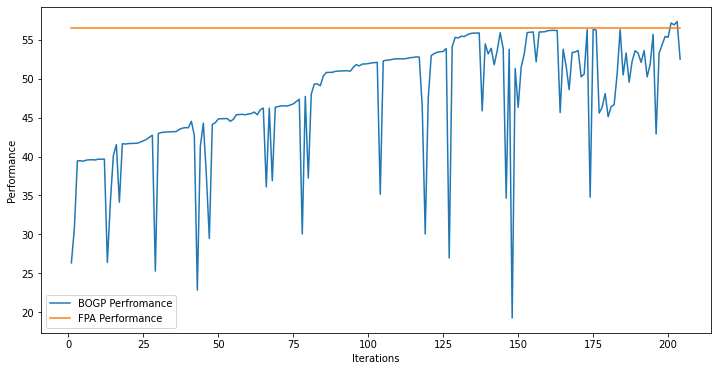

x_next is [ 29.98303618  29.95973047  -4.36448177  24.15296637  29.92180899
  29.9922553    9.49239702  29.97339465 -30.97828163   6.91103147
  29.93900528   1.90482442  29.99000095  29.96731561   4.91190115
  29.99627444  29.95110001  29.99352187  15.71675902  29.98051022]
f()=57.444503, actual=57.435
9


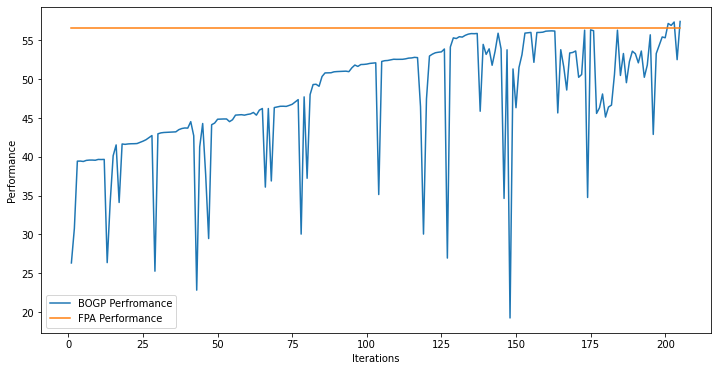

x_next is [  4.48133963   1.78644206   8.2360563    1.73595029 -17.29578222
   5.91835081  -1.32944286   4.9590868   14.55617243 -23.07489632
  12.8874597  -10.52426873 -20.61172892  -3.90249025  16.41814986
  -6.37828054   2.17442118 -27.01133148  10.75063296 -29.69475732]
f()=47.568279, actual=24.505
10


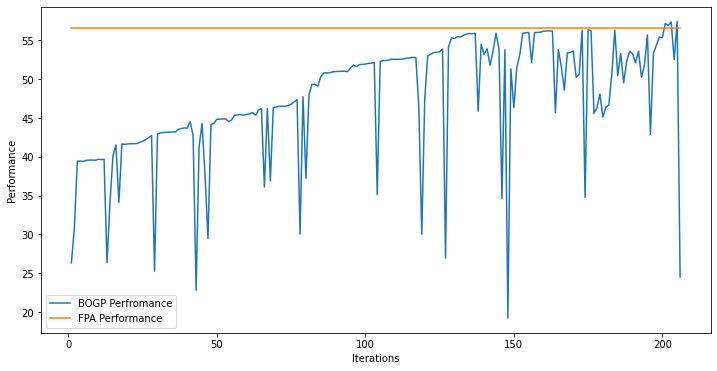

x_next is [ 29.96678615  29.92424499  -4.46274806  24.11536316  29.95547617
  29.9992832    9.5568403   29.97050737 -30.99147732   6.87453736
  29.87852337   1.91175605  29.99751825  29.9334833    4.92328481
  29.96327024  29.94268025  29.98804398  16.31078993  29.97979375]
f()=57.464520, actual=57.490
11


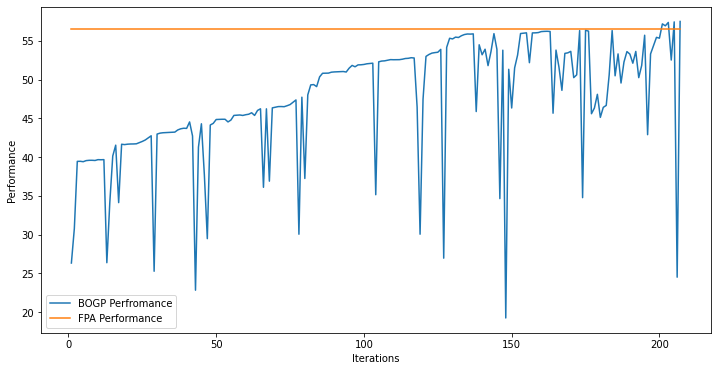

x_next is [ 29.96585945  29.81314052  -4.65322396  23.88995092  29.97508098
  29.97723677   9.47812688  29.97636935 -30.95312431   6.93677089
  29.77646154   1.7305456   29.9838965   29.93382786   4.87122058
  29.92625122  29.9089774   29.99715706  17.00750919  29.96008946]
f()=57.552624, actual=57.559
12


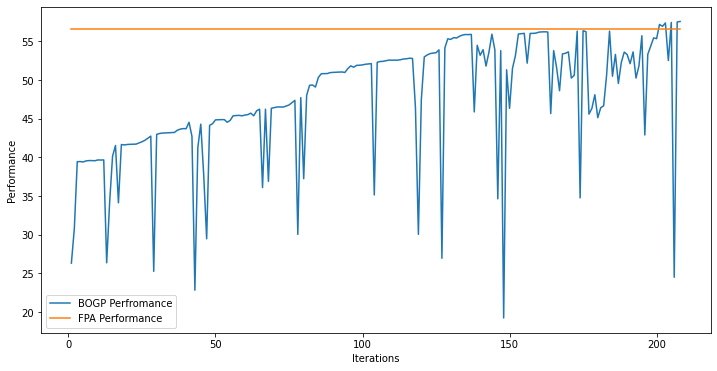

x_next is [ 29.96744759  29.45669217  -5.04153933  23.14160466  29.98111701
  29.9278467    8.98608475  29.99930928 -30.78449364   7.40698933
  29.54408377   0.96869737  29.99925708  29.98441602   4.60863656
  29.83456885  29.88108286  29.99862951  18.18568657  29.98802413]
f()=57.662800, actual=57.701
13


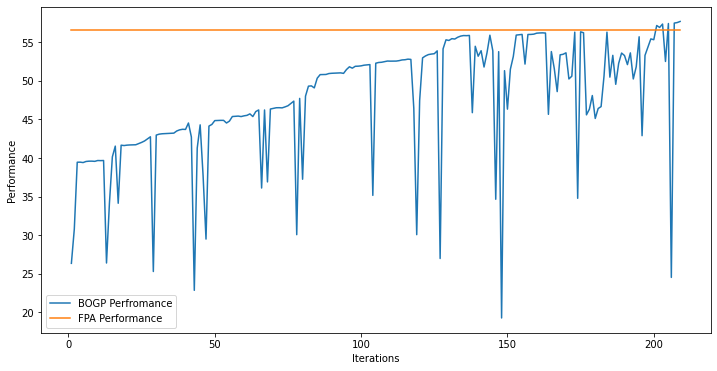

x_next is [ 29.98696985  28.96119717  -5.28895065  22.80732687  29.99285542
  29.91850115   8.52954076  29.96784121 -30.73192588   8.29328928
  29.2029411    0.07008582  29.99317413  29.88871884   4.20541458
  29.58716911  29.92804759  29.95920317  18.61393193  29.99937152]
f()=57.800662, actual=57.796
14


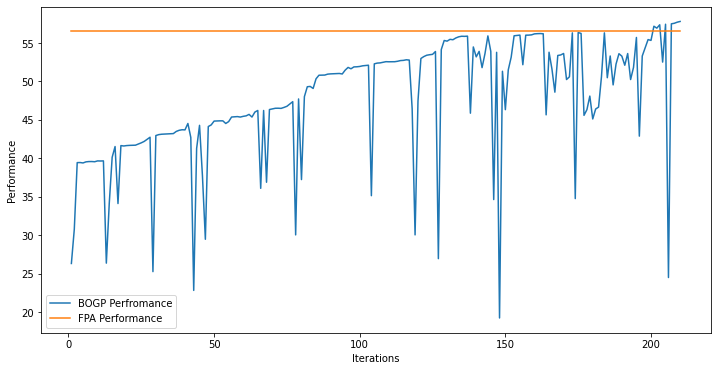

x_next is [ 29.99785172  28.484514    -5.44875872  22.96253905  29.99654896
  29.9431638    8.29946097  29.99419108 -30.83811433   9.19959896
  28.81531887  -0.64446745  29.99112004  29.6771104    3.88361777
  29.25493052  29.97588063  29.99572507  18.76484814  29.99081038]
f()=57.853736, actual=57.857
15


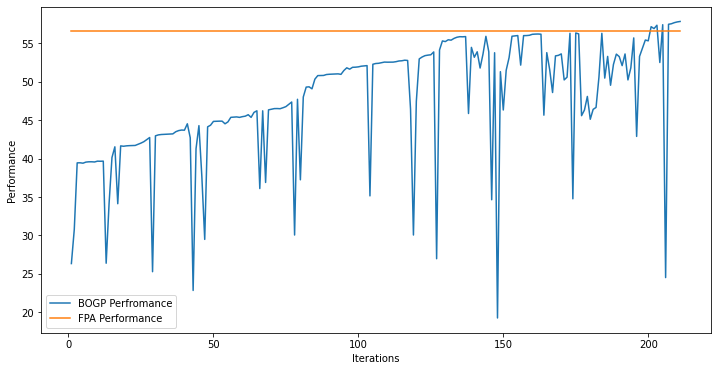

x_next is [-12.22356075   6.28475669 -15.4171535    0.36294084  -1.41786743
   9.64413433 -30.84736799 -10.86911383  25.28321426 -16.13350412
   7.30267295 -30.50525239   0.63511341  -7.82968546 -20.54917723
  -1.61776216  -3.62488298   5.02559599  19.68483902  -0.19099965]
f()=47.698284, actual=26.247
16


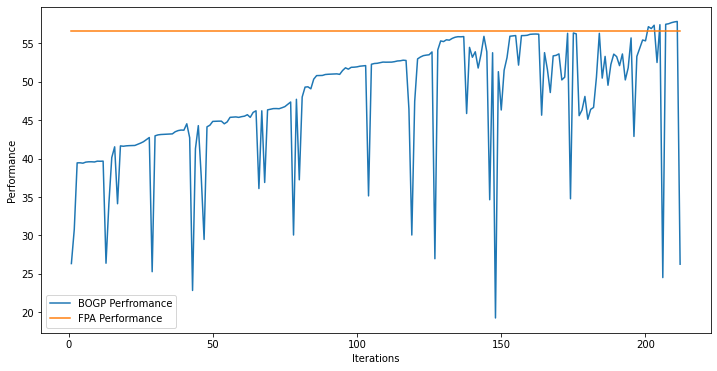

x_next is [ 29.99006492  28.07280075  -5.5534018   23.34062497  29.99470938
  29.99239481   8.18352786  29.99102079 -30.98437727   9.91818683
  28.43444318  -1.16540108  29.99653146  29.41940654   3.64180919
  28.92150977  29.99704727  29.99557033  18.76599148  29.99953068]
f()=57.884796, actual=57.862
17


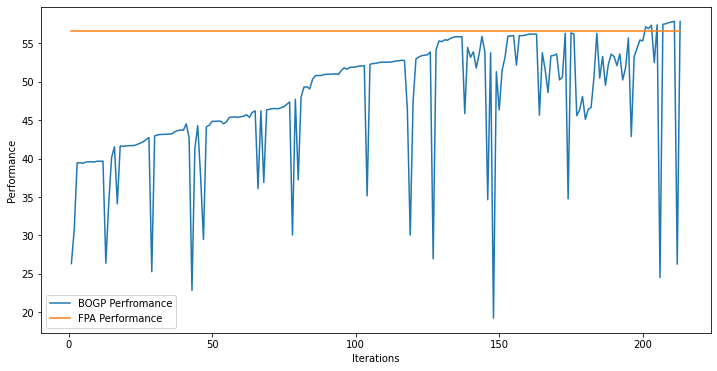

x_next is [ 29.98774094  28.10926334  -5.53122549  23.09112932  29.99943091
  29.99703622   8.17325724  29.99865486 -30.99617351   9.7660755
  28.55155613  -1.07049533  29.99254348  29.4177984    3.73834197
  28.97133156  29.99966446  29.9933781   18.81633197  29.99363902]
f()=57.864932, actual=57.858
18


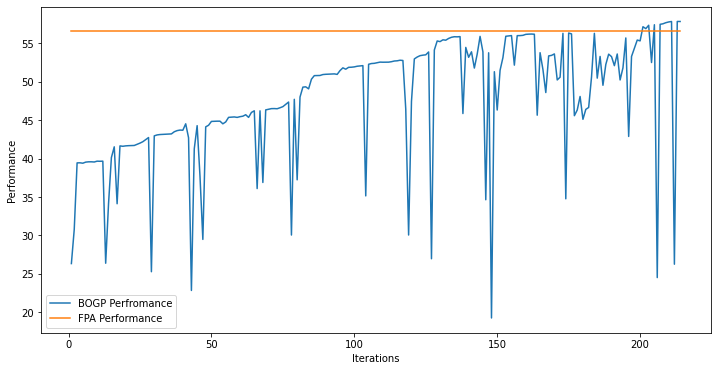

In [ ]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(20):
  x_next = opt_acquisition(X, y, model)

  np.save("/content/drive/MyDrive/trainingx_BOGP_PI_P=30.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_PI_P=30.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_PI_P=30.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)

  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()


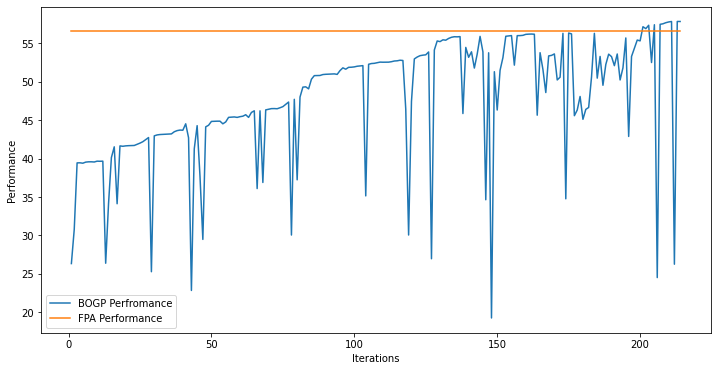

P_max = 30.000, Optimal_SE = 57.862
P_max = 30.000, Optimal_SE_FPA = 56.571


In [8]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

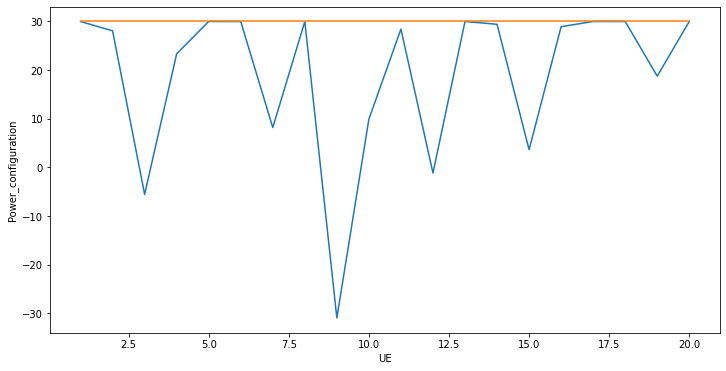

Power_configuration_BOGP is [ 29.99006492  28.07280075  -5.5534018   23.34062497  29.99470938
  29.99239481   8.18352786  29.99102079 -30.98437727   9.91818683
  28.43444318  -1.16540108  29.99653146  29.41940654   3.64180919
  28.92150977  29.99704727  29.99557033  18.76599148  29.99953068]


In [9]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.figure(figsize = (12, 6)) 
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:])
pyplot.plot(np.arange(1,21),X_FPA[:])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

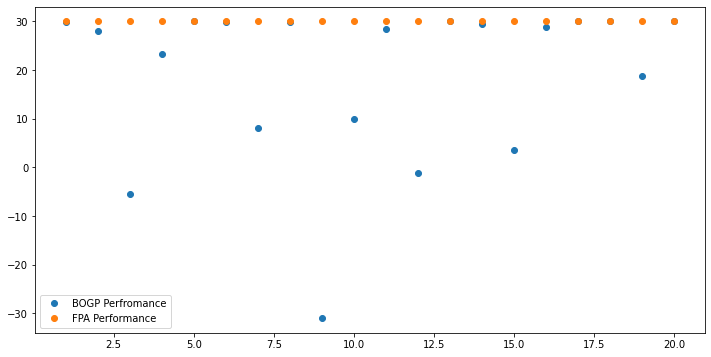

Power_configuration_BOGP is [ 29.99006492  28.07280075  -5.5534018   23.34062497  29.99470938
  29.99239481   8.18352786  29.99102079 -30.98437727   9.91818683
  28.43444318  -1.16540108  29.99653146  29.41940654   3.64180919
  28.92150977  29.99704727  29.99557033  18.76599148  29.99953068]


In [10]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])